# Clustering performance

Before we start generating clusterings, we need to decide how we will evaluate them. Recall that a clustering is simply a partitioning of the sample points into disjoint subsets. I'm going to use some nonstandard terminology that makes the definitions a bit easier to state and read.

````{prf:definition}
:label: definition-performance-buddies
We say that two sample points in a clustering are **buddies** if they are in the same cluster, and **strangers** otherwise. 
````

## (Adjusted) Rand index

If a trusted or ground-truth clustering is available, then we can compare it to any other clustering result. This allows us to use classification datasets as proving grounds for clustering, although the problems of classification and clustering have different goals (separation versus similarity).

Let $b$ be the number of pairs that are buddies in both clusterings, and let $s$ be the number of pairs that are strangers in both clusterings. Noting that there are $\binom{n}{2}$ distinct pairs of $n$ sample points, we define the **Rand index** by

$$
\text{RI} = \frac{b+s}{\binom{n}{2}}.
$$

One attractive feature of the Rand index is that there is no need to find a correspondence between the clusters in the two clusterings. In fact, the clusterings need not even have the same number of clusters.

While the Rand index is not hard to understand, it's not normalized to any obvious scale. The **adjusted Rand index** is

$$
\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\text{max}(\text{RI})-E[\text{RI}]},
$$

where the mean and max operations are taken over all possible clusterings. (These values can be worked out by combinatorics.) An ARI of 0 indicates no better agreement than a random clustering, and an ARI of 1 is complete agreement. 

## Silhouettes

If no reference clustering is available, then we must use an intrinsic measurement to assess quality. Suppose $\bfx_i$ is a sample point. Let $\bar{b}_i$ be the mean distance between $\bfx_i$ and its buddies, and let $\bar{r}_i$ be the mean distance between $\bfx_i$ and the members of the nearest cluster of strangers. Then the **silhouette value** of $\bfx_i$ is 

$$
s_i = \frac{\bar{r}_i-\bar{b}_i}{\max\{\bar{r}_i,\bar{b}_i\}}.
$$

This value is between $-1$ (bad) and $1$ (good) for every sample point. A **silhouette score** is derived by taking a mean of the silhouette values, either per cluster or overall depending on the usage.

::::{prf:example}
:label: example-performance-silhouette
Suppose that two clusters in one dimension are defined as $A=\{-4,-1,1\}$ and $B=\{2,6\}$. Find the silhouette values of all the samples, the silhouette scores of the clusters, and the overall silhouette score.
:::{dropdown} Solution

|  $x_i$ | $\bar{b}_i$ | $\bar{r}_i$ | $s_i$  | 
|:-------------:|:---------:|:----------:|:------:|
| $-4$   | $\frac{3+5}{2}$  | $\frac{6+10}{2}$  |  $\frac{8-4}{8}=\frac{1}{2}$  | 
| $-1$   | $\frac{3+2}{2}$  | $\frac{3+7}{2}$  |  $\frac{5-2.5}{5}=\frac{1}{2}$  | 
| $1$   | $\frac{5+2}{2}$  | $\frac{1+5}{2}$  |  $\frac{3-3.5}{3.5}=-\frac{1}{7}$  | 
| $2$   | $\frac{4}{1}$  | $\frac{6+3+1}{3}$  |  $\frac{(10/3)-4}{4}=-\frac{1}{6}$  | 
| $6$   | $\frac{4}{1}$  | $\frac{10+7+5}{3}$  |  $\frac{(22/3)-4}{(22/3)}=\frac{5}{11}$  | 

The silhouette score of cluster $A$ is 

$$
\frac{1}{3}\left( \frac{1}{2} + \frac{1}{2} - \frac{1}{7} \right) \approx 0.286,
$$

and of cluster $B$ is 

$$
\frac{1}{2}\left( \frac{5}{11} - \frac{1}{6} \right) \approx 0.144. 
$$

The overall score is the mean of the five values in the last column, which is about $0.229$.
:::
::::

## Toy example

We create an artificial data set with two features and three predefined clusters.

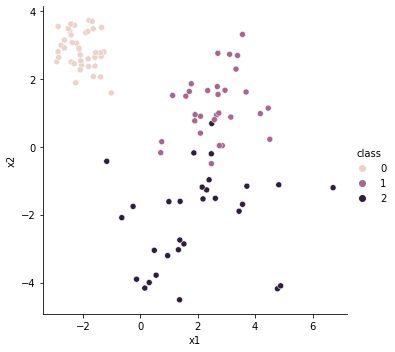

In [1]:
from sklearn.datasets import make_blobs
X,y = make_blobs(
    n_samples=[40,30,30],
    centers=[[-2,3],[3,1.5],[2,-2]],
    cluster_std=[0.5,0.9,1.5],   # std dev in each cluster
    random_state = 19716
    )

import pandas as pd
import seaborn as sns
blobs = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"class":y})
sns.relplot(data=blobs,x="x1",y="x2",hue="class");

As you can see above, class 2 is more dispersed than the other clusters, and, given the overlaps, a person might label a few points differently.

We will add a column to the data frame that records the silhouette score for each point.

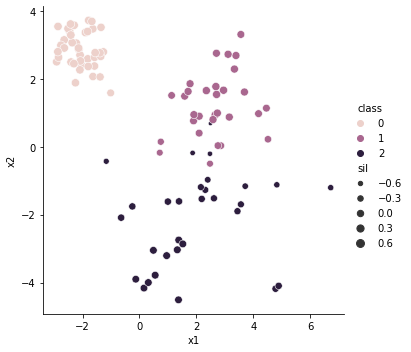

In [2]:
from sklearn.metrics import silhouette_samples
blobs["sil"] = silhouette_samples(X,y)
sns.relplot(data=blobs,x="x1",y="x2",hue="class",size="sil");

In this plot, the size of the dot shows its silhouette coefficient. Those points which don't belong comfortably with their cluster have negative scores and the smallest dots. We can find the average score in each cluster through a grouped mean:

In [3]:
blobs.groupby("class")["sil"].mean()

class
0    0.812718
1    0.551222
2    0.223225
Name: sil, dtype: float64

These values are ordered as we would expect.

Now let's create another clustering based on the quadrants of the plane.

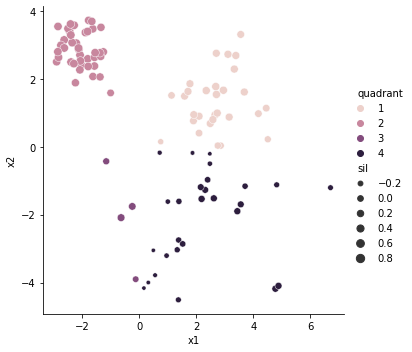

In [4]:
def quad(x,y):
    if x > 0:
        if y > 0: return 1
        else: return 4
    else:
        if y > 0: return 2
        else: return 3

blobs["quadrant"] = [quad(x,y) for (x,y) in zip(blobs.x1,blobs.x2)]
blobs["sil"] = silhouette_samples(X,blobs["quadrant"])
sns.relplot(data=blobs,x="x1",y="x2",hue="quadrant",size="sil");

In [5]:
blobs.groupby("quadrant")["sil"].mean()

quadrant
1    0.578120
2    0.808252
3    0.409983
4    0.043896
Name: sil, dtype: float64

Even though the original clustering had three classes, and there are four quadrants, we can still compare them by adjusted Rand index.

In [6]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y,blobs["quadrant"])

0.8784845217926999

Not surprisingly, they are seen as fairly similar.

## Digits

sklearn has a well-known dataset that contains labeled handwritten digits. Let's extract the examples for just the numerals 4, 5, and 6.

In [7]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)["frame"]
X = digits.drop("target",axis=1)
y = digits.target
keep = (y==4) | (y==5) | (y==6)
X = X[keep]
y = y[keep]
print(y.value_counts())

5    182
4    181
6    181
Name: target, dtype: int64


We can visualize the raw data. Here are some of the 6s.

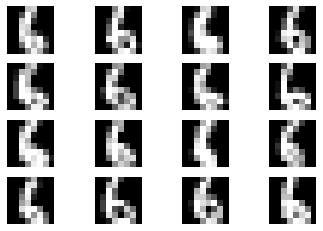

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_digits(X):
    fig, axes = plt.subplots(4,4)
    for i in range(4):
        for j in range(4):
            row = j + 4*i
            A = np.reshape(np.array(X.iloc[row,:]),(8,8))
            sns.heatmap(A,ax=axes[i,j],square=True,cmap="gray",cbar=False)
            axes[i,j].axis(False)
    return None

plot_digits(X[y==6])

A clustering method won't be able to learn from the ground truth labels. In order to set expectations, we should see how well the originally labels cluster the samples. Here are the mean silhouette scores for the clusters.

In [9]:
from sklearn.metrics import silhouette_samples
X["sil"] = silhouette_samples(X,y)
X["label"] = y.astype("category")
X.groupby("label")["sil"].mean()

label
4    0.194477
5    0.225677
6    0.327088
Name: sil, dtype: float64

As usual, means can tell us only so much. A look at the distributions of the values reveals more details:

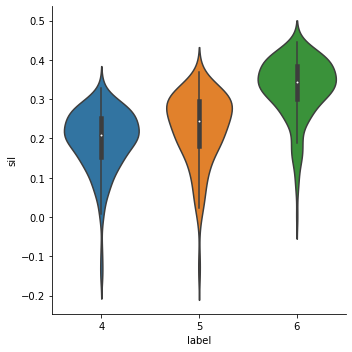

In [10]:
sns.catplot(data=X,x="label",y="sil",kind="violin");

The values are mostly positive, which indicates nearly all of the samples for a digit are at least somewhat closer to each other than to the other samples. The 6s are the most distinct. The existence of values close to and below zero suggest that a clustering algorithm might reconstruct the classification to some extent, but the ground truth may represent something more than geometric distances in feature space.

It's important to keep in mind that while classification just requires us to separate different classes of examples, clustering is more demanding: examples in a cluster need to be more like each other, or the "average" cluster member, than they are like members of other clusters. We should expect that edge cases, even within the training data, will look ambiguous.